In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os 

In [4]:
train_dir='/home/chirag/medical_classification_project/Data/balanced_train'
test_dir='/home/chirag/medical_classification_project/Data/test'
val_dir='/home/chirag/medical_classification_project/Data/val'

print("Train: ",os.listdir(train_dir))
print("Test: ",os.listdir(test_dir))
print("Validatioin: ",os.listdir(val_dir))

Train:  ['PNEUMONIA', 'NORMAL']
Test:  ['PNEUMONIA', 'NORMAL']
Validatioin:  ['PNEUMONIA', 'NORMAL']


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
img_size=(224,224)
batch_size=32
traingen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    height_shift_range=0.4,
    width_shift_range=0.4,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'

)
testgen=ImageDataGenerator(rescale=1./255)
valgen=ImageDataGenerator(rescale=1./255)

In [6]:
traindata=traingen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)
valdata=valgen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)
testdata=testgen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 2600 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Dropout,BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [8]:
base_model=DenseNet121(weights='imagenet',include_top=False,input_shape=(224,224,3))


# Freeze the base model layers except the last 20 layers
for layer in base_model.layers[:-20]:
    layer.trainable = False
for layer in base_model.layers[-20:]:
    layer.trainable = True

I0000 00:00:1739988647.585607   23644 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1207 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 602s 21us/step


In [26]:
model = Sequential()

model.add(base_model)
model.add(GlobalAveragePooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

In [27]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,334,465 (27.98 MB)

 Trainable params: 663,361 (2.53 MB)

 Non-trainable params: 6,671,104 (25.45 MB)

In [28]:
model.compile(
    optimizer=Adam(learning_rate=0.00005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [29]:
early_stop=EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1,
    mode='min'
)
lr_scheduler=ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-7,
    verbose=1
)
history=model.fit(traindata,validation_data=valdata,epochs=50,callbacks=[lr_scheduler,early_stop])

Epoch 1/50
51/82 ━━━━━━━━━━━━━━━━━━━━ 15s 498ms/step - accuracy: 0.4940 - loss: 1.1458

2025-02-20 00:06:44.234668: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_1', 24 bytes spill stores, 24 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_5', 24 bytes spill stores, 24 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_6', 16 bytes spill stores, 16 bytes spill loads



82/82 ━━━━━━━━━━━━━━━━━━━━ 59s 511ms/step - accuracy: 0.5306 - loss: 1.0663 - val_accuracy: 0.6250 - val_loss: 0.6123 - learning_rate: 5.0000e-05
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 28s 343ms/step - accuracy: 0.7484 - loss: 0.5997 - val_accuracy: 0.6875 - val_loss: 0.5488 - learning_rate: 5.0000e-05
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 28s 343ms/step - accuracy: 0.8157 - loss: 0.4927 - val_accuracy: 0.8750 - val_loss: 0.4757 - learning_rate: 5.0000e-05
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 28s 345ms/step - accuracy: 0.8402 - loss: 0.4550 - val_accuracy: 0.8750 - val_loss: 0.4397 - learning_rate: 5.0000e-05
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 28s 339ms/step - accuracy: 0.8635 - loss: 0.3915 - val_accuracy: 0.8750 - val_loss: 0.4414 - learning_rate: 5.0000e-05
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 28s 342ms/step - accuracy: 0.8747 - loss: 0.3850 - val_accuracy: 0.8750 - val_loss: 0.4413 - learning_rate: 5.0000e-05
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 29s 348ms/step - accuracy: 0.88

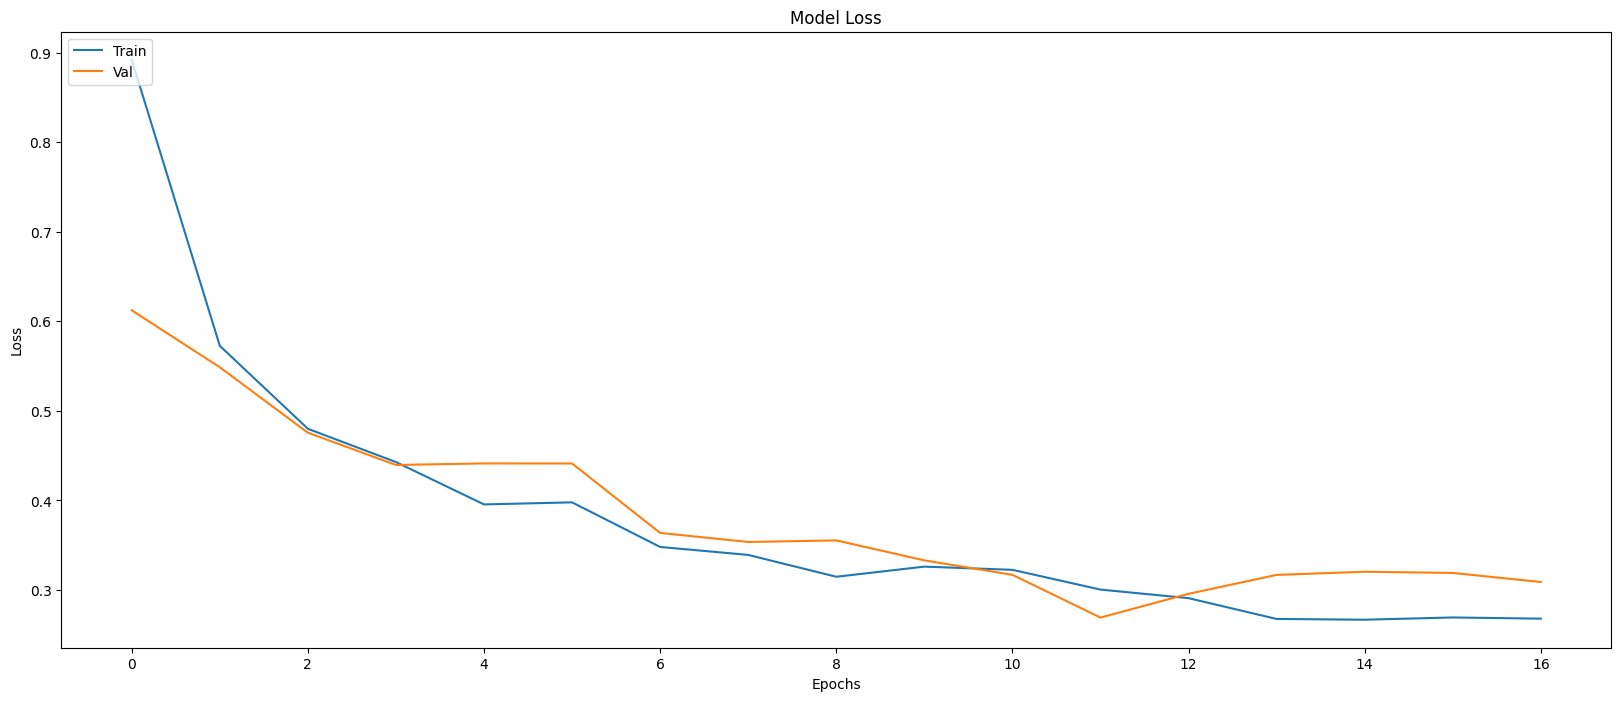

In [30]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train','Val'],loc='upper left')
plt.show()

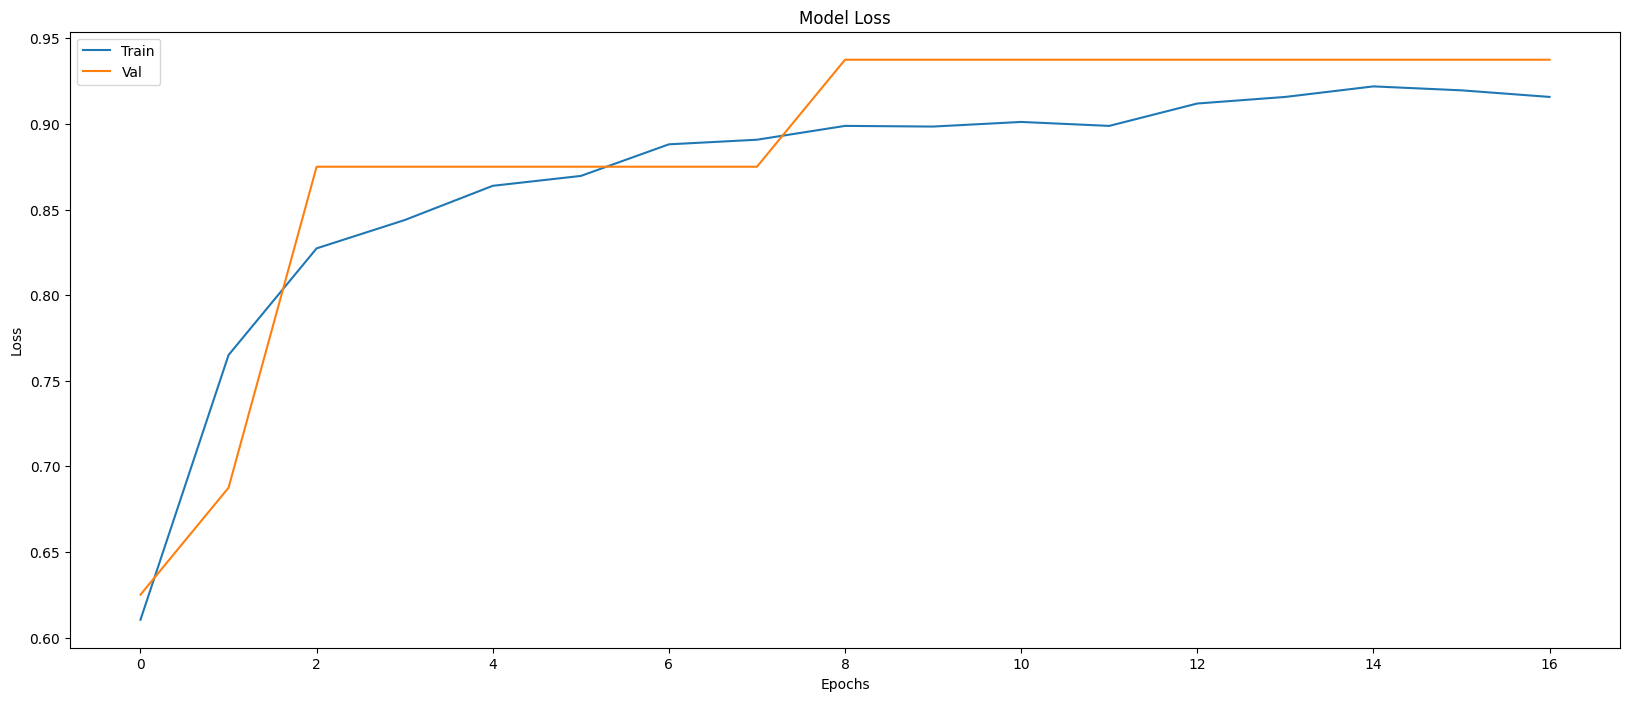

In [31]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train','Val'],loc='upper left')
plt.show()

In [32]:
test_loss, test_accuracy = model.evaluate(testdata)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - accuracy: 0.9213 - loss: 0.2530
Test Loss: 0.31791338324546814
Test Accuracy: 0.8910256624221802


20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 400ms/step


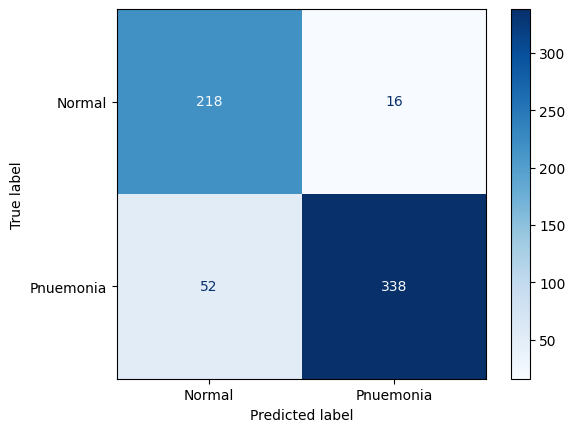

In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report
#confusion matrix
true_labels=testdata.classes

prediction=model.predict(testdata)
predicted_labels=(prediction>0.5).astype(int).flatten()

conf_matrix=confusion_matrix(true_labels,predicted_labels)
disp=ConfusionMatrixDisplay(conf_matrix,display_labels=['Normal','Pnuemonia'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [34]:
#Classification report
print("Classification Report")
print(classification_report(true_labels,predicted_labels))

Classification Report
              precision    recall  f1-score   support

           0       0.81      0.93      0.87       234
           1       0.95      0.87      0.91       390

    accuracy                           0.89       624
   macro avg       0.88      0.90      0.89       624
weighted avg       0.90      0.89      0.89       624



In [35]:
y_pred_prob=model.predict(testdata)
if y_pred_prob.shape[1] > 1:  
    y_pred_prob = y_pred_prob[:, 1]  # Take the probability for class 1 (Pneumonia)
else:
    y_pred_prob = y_pred_prob.flatten()  # If binary, the array may already be 1D


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step


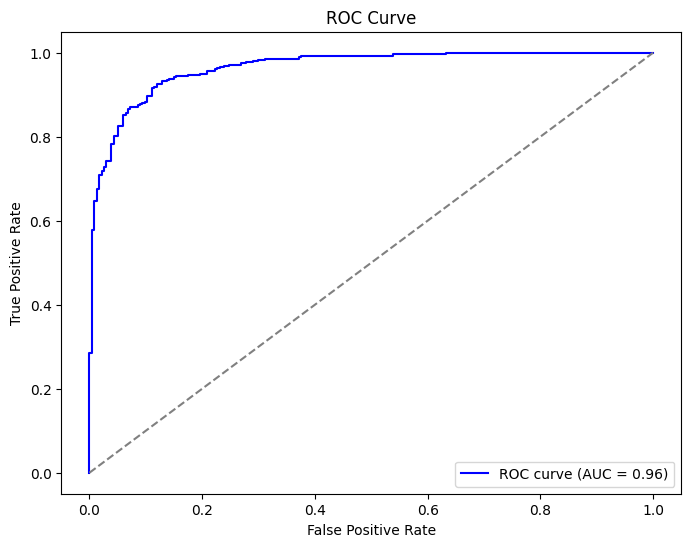

In [36]:
from sklearn.metrics import auc,roc_curve
#tpr=True positive rate : should be high 
#fpr=false positive rate : should be low i.e lower false prediction

fpr, tpr, thresholds = roc_curve(true_labels, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [37]:
model.save('model_DenseNet121.keras')